# NN 2.0

## Defining data functions

Import needed libraries

In [1]:
# imports
import pandas as pd
import tensorflow as tf
import tensorflow.keras as ks
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

Get data from file and remove columns with text

In [2]:
def get_swissvotes_data()->pd.DataFrame:
    import re
    
    dataset = pd.read_csv("../data/formatted/swissvotes_dataset_after_1900_utf8.csv", sep=';')
    
    regex = re.compile("pdev_.*")
    to_excl = list(filter(regex.match, dataset.columns))
    
    dataset.drop(columns=to_excl, inplace=True)
    dataset.drop(columns=["legisjahr"], inplace=True)
    dataset.drop(columns=["titel_kurz_d", "titel_kurz_f", "titel_off_d", "titel_off_f", "stichwort"], inplace=True)
    dataset.drop(columns=["swissvoteslink", "anzahl", "anneepolitique", "bkchrono_de", "bkchrono_fr"], inplace=True)
    dataset.drop(columns=["curiavista_de", "curiavista_fr", "urheber", "bkresults_de", "bkresults_fr"], inplace=True)
    dataset.drop(columns=["bfsmap_de", "bfsmap_fr", "nach_cockpit_d", "nach_cockpit_f", "nach_cockpit_e"], inplace=True)
    dataset = dataset[dataset["anr"] < 646] # we don't care about future votes
    
    return dataset
print(f"Defined {get_swissvotes_data}")

Defined <function get_swissvotes_data at 0x000001C7840BFD30>


In [3]:
def get_rechtsform_onehot(data:pd.DataFrame = get_swissvotes_data())->pd.DataFrame:
    tensor = tf.one_hot(data["rechtsform"], 5).numpy();
    result = pd.DataFrame(tensor, columns=["ref_obl", "ref_fak", "initiative", "gegen_entw", "stichfr"], index=data.index)
    
    return result.astype(int)
print(f"Defined {get_rechtsform_onehot}")

Defined <function get_rechtsform_onehot at 0x000001C7840CAF70>


In [4]:
def get_politikbereich_multihot(data:pd.DataFrame = get_swissvotes_data())->pd.DataFrame:
    polber = data[["d1e1", "d2e1", "d3e1"]]
    polber = polber.replace('.', 0)
    polber = polber.astype(int)
    
    # the names of the columns (they're a bit long)
    cols = ["Staatsordnung", "Aussenpolitik", "Sicherheitspolitik", "Wirtschaft"]
    cols += ["Landwirtschaft", "Öffentliche Finanzen", "Energie", "Verkehr und Infrastruktur"]
    cols += ["Umwelt und Lebensraum", "Sozialpolitik", "Bildung und Forschung", "Kultur, Religion, Medien"]
    
    result = pd.DataFrame(columns=cols, index = data.index)
    for i in range(len(result)):
        row = np.zeros(12)
        for p in polber.iloc[i]:
            if p != 0:
                row[p-1] = 1
        result.iloc[i] = row
    return result.astype(int)

print(f"Defined {get_politikbereich_multihot}")

Defined <function get_politikbereich_multihot at 0x000001C7845E1E50>


In [5]:
def get_department_onehot(data:pd.DataFrame = get_swissvotes_data())->pd.DataFrame:
    dep_single = data["dep"].replace('.', 2) # voting at age 18 is the only vote with a '.' and it's dep of inner
    dep_single = dep_single.astype(int)
    tensor = tf.one_hot(dep_single, 8).numpy()
    result = pd.DataFrame(tensor, columns=["EDA", "EDI", "EJPD", "VBS", "EFD", "WBF", "UVEK", "BK"], index=data.index)
    
    return result.astype(int)

print(f"Defined {get_department_onehot}")

Defined <function get_department_onehot at 0x000001C784155D30>


In [6]:
def get_bundesrat_onehot(data:pd.DataFrame = get_swissvotes_data())->pd.DataFrame:
    tensor = tf.one_hot(data["br_pos"].replace('.', 3).astype(int), 3).numpy()
    result = pd.DataFrame(tensor, columns=["Dafür_bund", "Dagegen_bund", "Keine_bund"], index=data.index)
    return result.astype(int)

print(f"Defined {get_bundesrat_onehot}")

Defined <function get_bundesrat_onehot at 0x000001C7841CEF70>


In [7]:
def get_legislatur(low:int=1, high:int=10, data:pd.DataFrame = get_swissvotes_data())->pd.DataFrame:
    leg = data["legislatur"]
    def my_map(x:int, x_min:int=leg.min(0), x_max:int=leg.max(0), y_min:int=low, y_max:int=high)->float:
        return (x-x_min)/(x_max-x_min)*(y_max-y_min)+y_min
    
    normalized = data[["legislatur"]].applymap(my_map)
    return normalized

print(f"Defined {get_legislatur}")

Defined <function get_legislatur at 0x000001C784155820>


In [8]:
def get_nationalrat_onehot(data:pd.DataFrame = get_swissvotes_data()["nr_pos"])->pd.DataFrame:
    tensor = tf.one_hot(data.astype(int), 3).numpy()
    result = pd.DataFrame(tensor, columns=["Dafür_nat", "Dagegen_nat", "Keine_nat"], index=data.index)
    return result.astype(int)

print(f"Defined {get_nationalrat_onehot}")

Defined <function get_nationalrat_onehot at 0x000001C784C11F70>


In [9]:
def get_ständerat_onehot(data:pd.DataFrame = get_swissvotes_data()["sr_pos"])->pd.DataFrame:
    tensor = tf.one_hot(data.astype(int), 3).numpy()
    result = pd.DataFrame(tensor, columns=["Dafür_std", "Dagegen_std", "Keine_std"], index=data.index)
    return result.astype(int)

print(f"Defined {get_ständerat_onehot}")

Defined <function get_ständerat_onehot at 0x000001C784155550>


In [10]:
def get_parties(data:pd.DataFrame = get_swissvotes_data())->list:
    import re
    
    regex_incl = re.compile("p_.*")
    regex_excl = re.compile("p_others_.*")
    
    parties_pre = list(filter(regex_incl.match, data.columns))
    parties = [p for p in parties_pre if not regex_excl.match(p)]
    return parties

print(f"Defined {get_parties}")

Defined <function get_parties at 0x000001C784ACC8B0>


In [11]:
def normalize_party_reco(data:pd.DataFrame = get_swissvotes_data(), names:list = get_parties())->pd.DataFrame:
    # deal with unwanted values first
    normalized = data[names].replace(".", 0)
    normalized.replace(np.nan, 0, inplace=True)
    normalized = normalized.astype(int)
    normalized.replace([3,4,5,66,9999], 0, inplace=True)
    
    result = pd.DataFrame(index=normalized.index)
    
    for p in names: # go through parties and create one hot encoding
        tensor = tf.one_hot(normalized[p], 3).numpy()
        temp = pd.DataFrame(tensor, columns=[p+"_neutral", p+"_ja", p+"_nein"], index=result.index)
        result = result.join(temp)

    return result.astype(int)
print(f"Defined {normalize_party_reco}")

Defined <function normalize_party_reco at 0x000001C7840CA040>


In [12]:
def get_vote_result(data:pd.DataFrame = get_swissvotes_data())->pd.DataFrame:
    result = data["annahme"].replace('.', 0)
    return result.astype(int)

print(f"Defined {get_vote_result}")

Defined <function get_vote_result at 0x000001C784BABD30>


In [13]:
# creates a dataframe 
def get_canton_results(data:pd.DataFrame = get_swissvotes_data())->pd.DataFrame:
    import re
    regex = re.compile(".*_annahme")
    canton_names = list(filter(regex.match, data.columns))
    return data[canton_names].replace('.', 0).astype(int)

print(f"Defined {get_canton_results}")

Defined <function get_canton_results at 0x000001C784F91F70>


In [14]:
def get_vote_result_proz(data:pd.DataFrame = get_swissvotes_data())->pd.DataFrame:
    result = data["volkja_proz"].replace('.', 0)
    result = result.apply(lambda x: x/100)
    return result.astype(float)

print(f"Defined {get_vote_result_proz}")

Defined <function get_vote_result_proz at 0x000001C784BAB790>


In [15]:
# creates a dataframe 
def get_canton_results_proz(data:pd.DataFrame = get_swissvotes_data())->pd.DataFrame:
    import re
    regex = re.compile(".*_japroz")
    canton_names = list(filter(regex.match, data.columns))
    result = data[canton_names].replace('.', 0)
    result.dropna(inplace=True)
    result = result.apply(lambda x: x/100)
    return result.astype(float)

print(f"Defined {get_canton_results_proz}")

Defined <function get_canton_results_proz at 0x000001C7851BDDC0>


## Training the net

In [16]:
# get data
def get_data():
    swissvotes = get_swissvotes_data()
    # the inputs used by the neural net are:
        # Rechtsform (one hot),
        # Politikbereich (multi hot),
        # Department (one hot),
        # Position of the Bundesrat (one hot),
        # legislatur (normalized from 1-10),
        # Position of Nationalrat (one hot),
        # Position of Ständerat (one hot),
        # Party recommendations (one hot)
    in_rchtfrm = get_rechtsform_onehot()
    in_poltber = get_politikbereich_multihot()
    in_deprtmt = get_department_onehot()
    in_burapos = get_bundesrat_onehot()
    in_legsltr = get_legislatur()
    in_narapos = get_nationalrat_onehot()
    in_strapos = get_ständerat_onehot()
    in_parties = normalize_party_reco()
    
    inputs = pd.concat([in_rchtfrm, in_poltber, in_deprtmt, in_burapos, in_narapos, in_strapos, in_parties, in_legsltr], axis=1)
    
    # the outputs are:
        # result of the votes (binary),
        # result on a canton level (binary)
    out_result = get_vote_result()
    out_canton = get_canton_results()
    
    outputs = pd.concat([out_result, out_canton], axis=1)
    
    return swissvotes, inputs, outputs

print(f"Defined {get_data}")

Defined <function get_data at 0x000001C7851BD5E0>


In [17]:
def create_model(input_size:int = len(get_data()[1].columns), hidden:list=[100, 50, 20],
                 output_size:int = len(get_data()[2].columns), activation:str="relu",
                 activation_output:str="sigmoid", 
                 optimizer=ks.optimizers.SGD(learning_rate=0.1), 
                 loss=ks.losses.BinaryCrossentropy())->ks.models.Sequential:
    model = ks.models.Sequential()
    
    model.add(ks.layers.Dense(units=input_size, activation=activation, name="Input"))
    
    for i in range(len(hidden)):
        model.add(ks.layers.Dense(units=hidden[i], activation=activation, name="Hidden_"+str(i)))
        model.add(ks.layers.Dropout(rate=.1, name="Dropout_"+str(i)))
        
    model.add(ks.layers.Dense(units=output_size, activation=activation_output, name="Output"))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=[ks.metrics.BinaryAccuracy(), 
                                                           ks.metrics.FalseNegatives()])
    
    return model

print(f"Defined {create_model}")

Defined <function create_model at 0x000001C7851BDAF0>


In [18]:
def train_model(model:ks.models.Sequential, inputs:pd.DataFrame=get_data()[1], 
                outputs:pd.DataFrame=get_data()[2], test_size:float=0.2, 
                batch_size:int=50, epochs:int=75, shuffle:bool=True)->tuple:
    from sklearn.model_selection import train_test_split as tts
    in_train, in_test, out_train, out_test = tts(inputs, outputs, test_size=test_size)
    
    history = model.fit(x=in_train, y=out_train, batch_size=batch_size, epochs=epochs, shuffle=shuffle)
    
    return history, in_test, out_test

print(f"Defined {train_model}")

Defined <function train_model at 0x000001C7850620D0>


In [19]:
model = create_model(hidden=[10, 20], 
                     loss=ks.losses.MeanAbsoluteError(), activation_output="sigmoid")

history, in_test, out_test = train_model(model, epochs=125)

print(model.summary())

Epoch 1/125

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 0s 500us/step - loss: 0.5004 - binary_accuracy: 0.4936 - false_negatives: 3465.0000
Epoch 2/125
10/10 [==============================] - 0s 500us/step - loss: 0.4990 - binary_accuracy: 0.5082 - false_negatives: 3547.0000
Epoch 3/125
10/10 [==============================] - 0s 400us/step - loss: 0.4977 - binary_accuracy: 0.5131 - false_negatives: 3654.0000
Epoch 4/125
10/10 [==============================] - 0s 400us/step - loss: 0.4967 - binary_accura

10/10 [==============================] - 0s 400us/step - loss: 0.3343 - binary_accuracy: 0.6870 - false_negatives: 1929.0000
Epoch 56/125
10/10 [==============================] - 0s 400us/step - loss: 0.3261 - binary_accuracy: 0.6950 - false_negatives: 1885.0000
Epoch 57/125
10/10 [==============================] - 0s 400us/step - loss: 0.3320 - binary_accuracy: 0.6829 - false_negatives: 1910.0000
Epoch 58/125
10/10 [==============================] - 0s 400us/step - loss: 0.3191 - binary_accuracy: 0.7013 - false_negatives: 1771.0000
Epoch 59/125
10/10 [==============================] - 0s 500us/step - loss: 0.3156 - binary_accuracy: 0.7038 - false_negatives: 1683.0000
Epoch 60/125
10/10 [==============================] - 0s 501us/step - loss: 0.3153 - binary_accuracy: 0.7056 - false_negatives: 1588.0000
Epoch 61/125
10/10 [==============================] - 0s 500us/step - loss: 0.3173 - binary_accuracy: 0.7032 - false_negatives: 1552.0000
Epoch 62/125
10/10 [===========================

10/10 [==============================] - 0s 500us/step - loss: 0.2609 - binary_accuracy: 0.7475 - false_negatives: 1302.0000
Epoch 115/125
10/10 [==============================] - 0s 400us/step - loss: 0.2627 - binary_accuracy: 0.7433 - false_negatives: 1320.0000
Epoch 116/125
10/10 [==============================] - 0s 501us/step - loss: 0.2652 - binary_accuracy: 0.7421 - false_negatives: 1235.0000
Epoch 117/125
10/10 [==============================] - 0s 400us/step - loss: 0.2645 - binary_accuracy: 0.7462 - false_negatives: 1369.0000
Epoch 118/125
10/10 [==============================] - 0s 400us/step - loss: 0.2554 - binary_accuracy: 0.7531 - false_negatives: 1286.0000
Epoch 119/125
10/10 [==============================] - 0s 400us/step - loss: 0.2534 - binary_accuracy: 0.7549 - false_negatives: 1335.0000
Epoch 120/125
10/10 [==============================] - 0s 501us/step - loss: 0.2581 - binary_accuracy: 0.7503 - false_negatives: 1307.0000
Epoch 121/125
10/10 [====================

In [20]:
model.evaluate(x=in_test, y=out_test)

4/4 [==============================] - 0s 500us/step - loss: 0.2436 - binary_accuracy: 0.7659 - false_negatives: 238.0000


[0.24359577894210815, 0.7659380435943604, 238.0]

In [32]:
def train_classifier(inputs:pd.DataFrame=get_data()[1],
                     outputs:pd.DataFrame=get_data()[2]['annahme'],
                     test_size:float=0.2, cutoff:float=.5,
                     shuffle:bool=False, scale_data:bool=False,
                     visualisation:bool=True,
                     in_train:list=None, in_test:list=None,
                     out_train:list=None, out_test:list=None)->tuple:
    if in_train is None or in_test is None or out_train is None or out_test is None:
        from sklearn.model_selection import train_test_split as tts
        cutoff=int(cutoff*len(inputs))
        in_train, in_test, out_train, out_test = tts(inputs[cutoff:], outputs[cutoff:], test_size=test_size, shuffle=shuffle)
    else: assert len(in_train)==len(out_train) and len(in_test)==len(out_test)
    
    if(scale_data):
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler().fit(in_train)
        in_train = scaler.transform(in_train)
        in_test = scaler.transform(in_test)
    
    out_pred = []
    
    from sklearn.linear_model import SGDClassifier, RidgeClassifier, RidgeClassifierCV
    from xgboost import XGBClassifier
    #from fracridge import FracRidgeRegressor, FracRidgeRegressorCV
    ridge = RidgeClassifier()
    ridge.fit(in_train,out_train)
    out_pred.append([ridge,'ridge', ridge.predict(in_test)])
    
    ridgecv = RidgeClassifierCV()
    ridgecv.fit(in_train,out_train)
    out_pred.append([ridgecv,'ridgecv', ridgecv.predict(in_test)])
    
    #fracridge = FracRidgeRegressor()
    #fracridge.fit(in_train,out_train)
    #out_pred.append([fracridge,'fracridge', fracridge.predict(in_test)])
    
    #fracridgecv = FracRidgeRegressorCV()
    #fracridgecv.fit(in_train,out_train)
    #out_pred.append([fracridge,'fracridge', fracridge.predict(in_test)])
    
    sgd = SGDClassifier(loss='log', penalty='elasticnet')
    sgd.fit(in_train, out_train)
    out_pred.append([sgd,'sgd', sgd.predict(in_test)])
    
    xgb = XGBClassifier()
    xgb.fit(in_train, out_train)
    out_pred.append([xgb,'xgb', xgb.predict(in_test)])
    
    if(visualisation):
        from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
        from xgboost import plot_importance
        errors = []
        errors.append(['r2_score', r2_score])
        errors.append(['mse', mean_squared_error])
        errors.append(['mae', mean_absolute_error])
        
        from sklearn.metrics import plot_confusion_matrix
        for i in out_pred:
            print(i[1], ': ')
            for j in errors:
                print(j[0], j[1](i[2],out_test),' ')
            plot_confusion_matrix(i[0],in_test,out_test)
            print('\n')
    
        fig, ax = plt.subplots(len(out_pred),1, figsize=(20,30))
        axe = ax.ravel()
        for i in range(0,len(out_pred)):
            sns.regplot(ax=axe[i], x=out_pred[i][2], y=out_test, x_bins=100)
            axe[i].set_title(out_pred[i][1])
            axe[i].set_xlabel('recommendations')
            axe[i].set_ylabel('Passed')
        
        plt.rcParams["figure.figsize"] = (15, 20)
        plot_importance(xgb)
        plt.rcParams["figure.figsize"] = (6.4, 4.8)
            
    return out_pred, out_test

D:\IDE\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:39:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ridge : 
r2_score 0.24436936936936937  
mse 0.18032786885245902  
mae 0.18032786885245902  


ridgecv : 
r2_score 0.3967032967032966  
mse 0.14754098360655737  
mae 0.14754098360655737  


sgd : 
r2_score -0.09909909909909875  
mse 0.26229508196721313  
mae 0.26229508196721313  


xgb : 
r2_score 0.5933333333333333  
mse 0.09836065573770492  
mae 0.09836065573770492  




([[RidgeClassifier(),
   'ridge',
   array([1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
          0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
          1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0])],
  [RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])),
   'ridgecv',
   array([1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
          0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
          1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0])],
  [SGDClassifier(loss='log', penalty='elasticnet'),
   'sgd',
   array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
          0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
          1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0])],
  [XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                 importance_type='gai

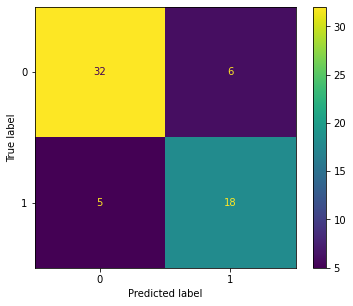

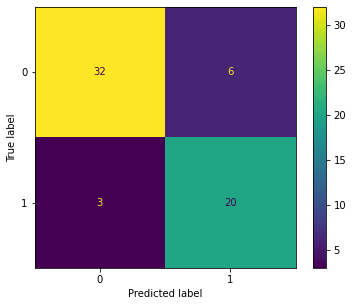

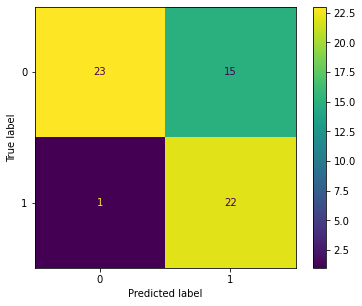

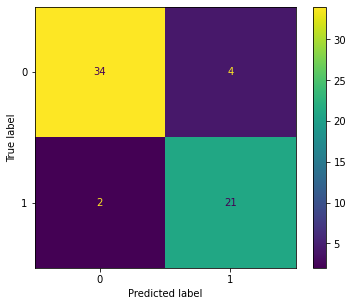

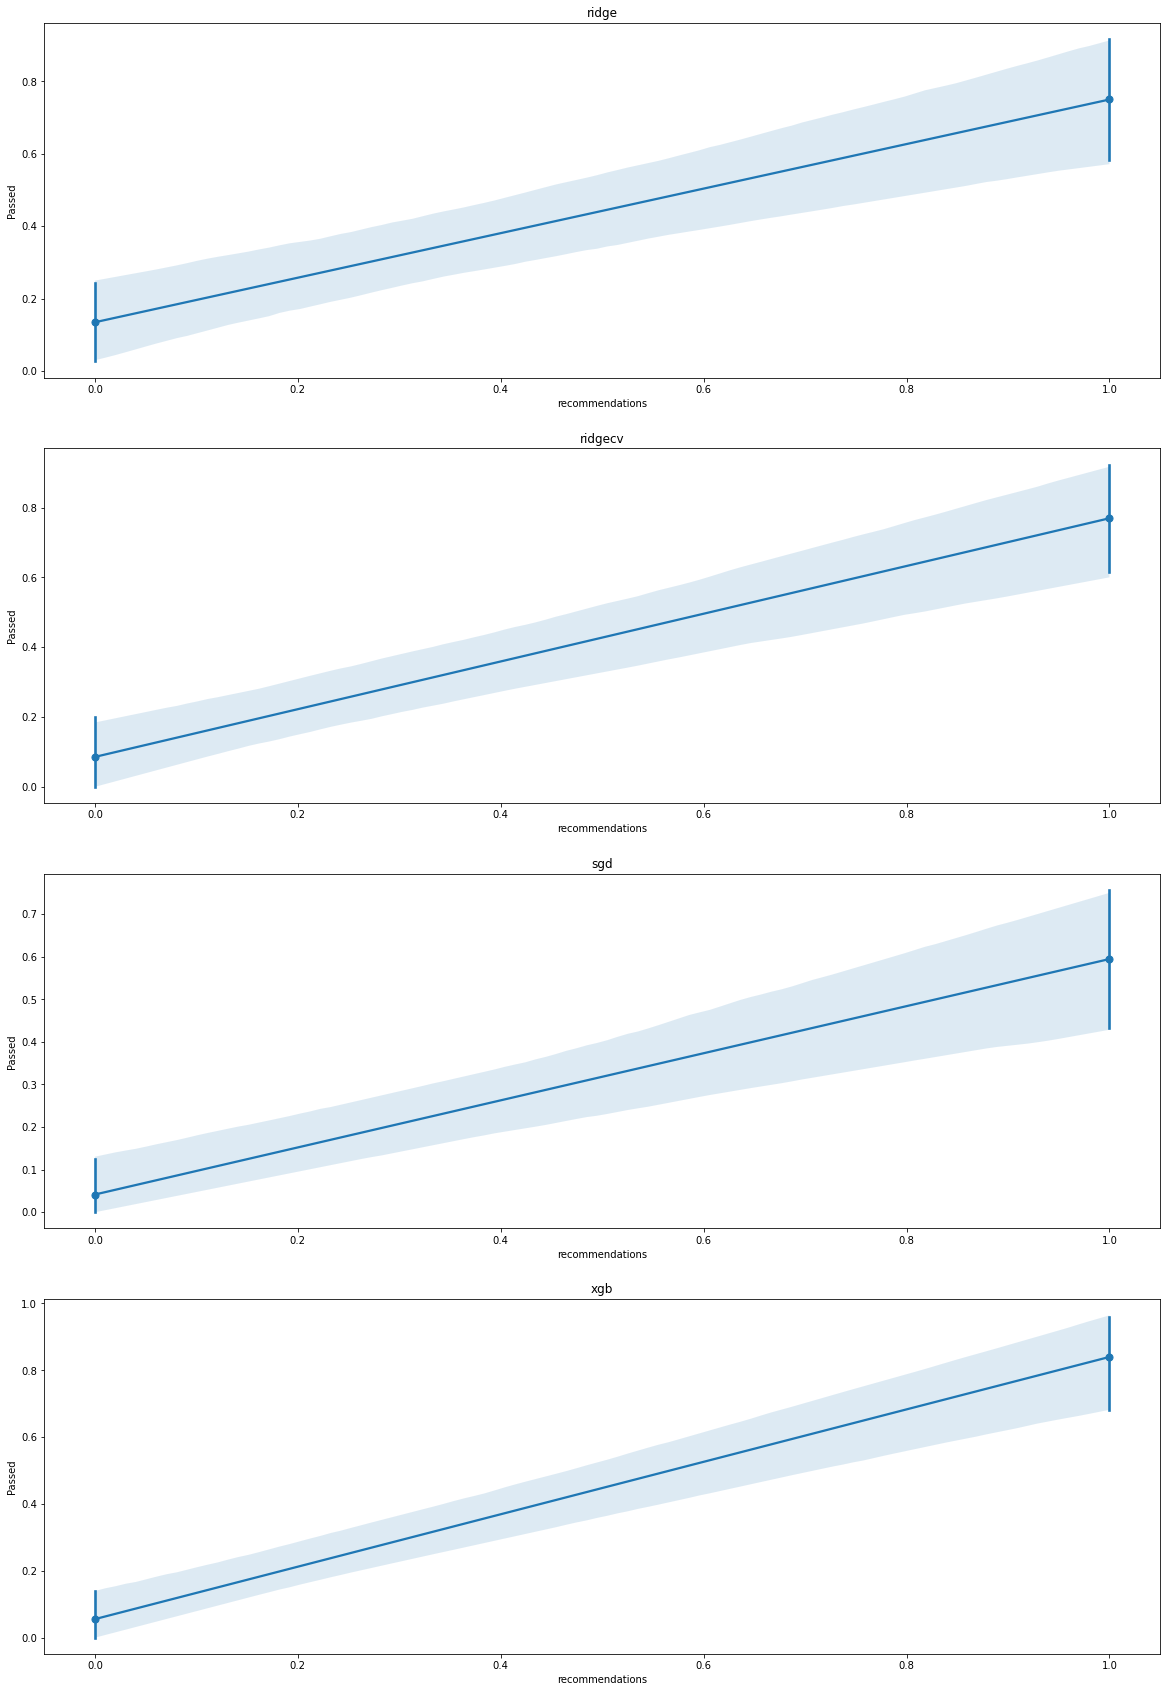

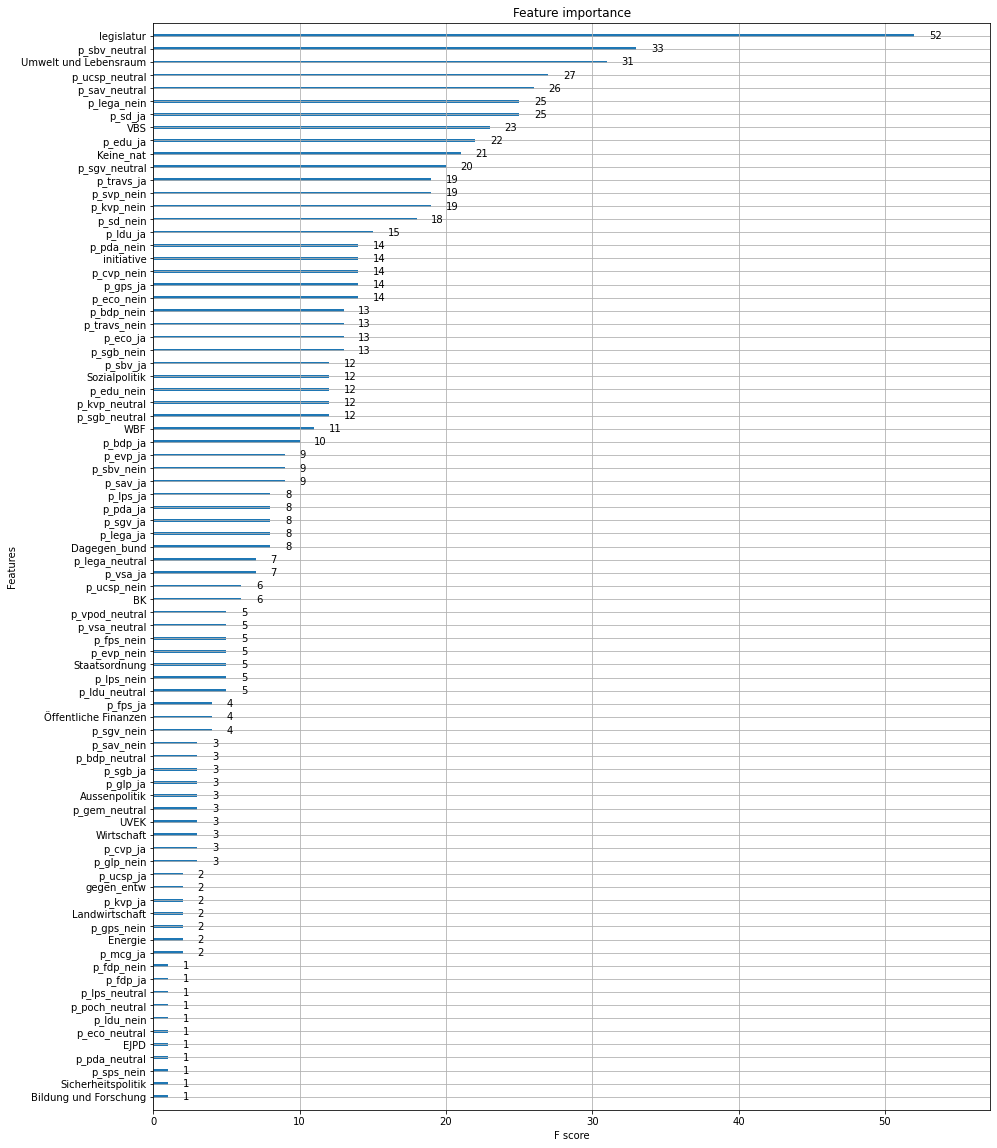

In [33]:
train_classifier(shuffle=True)

In [ ]:
 def get_outcomes_proz():
    out_result_proz = get_vote_result_proz()
    out_canton_proz = get_canton_results_proz()
    
    outputs_proz = pd.concat([out_result_proz, out_canton_proz], axis=1)
    
    return outputs_proz

In [ ]:
def train_regression(inputs:pd.DataFrame=get_data()[1],
                     outputs:pd.DataFrame=get_outcomes_proz()['volkja_proz'],
                     test_size:float=0.2, cutoff:float=.5,
                     shuffle:bool=False, scale_data:bool=False,
                     visualisation:bool=True,
                     in_train:list=None, in_test:list=None,
                     out_train:list=None, out_test:list=None)->tuple:
    if in_train is None or in_test is None or out_train is None or out_test is None:
        from sklearn.model_selection import train_test_split as tts
        cutoff=int(cutoff*len(inputs))
        in_train, in_test, out_train, out_test = tts(inputs[cutoff:], outputs[cutoff:], test_size=test_size, shuffle=shuffle)
    else: assert len(in_train)==len(out_train) and len(in_test)==len(out_test)
    
    if(scale_data):
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler().fit(in_train)
        in_train = scaler.transform(in_train)
        in_test = scaler.transform(in_test)
    
    out_pred = []
    
    from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
    from xgboost import XGBRegressor
    ridge = Ridge()
    ridge.fit(in_train,out_train)
    out_pred.append([ridge,'ridge', ridge.predict(in_test)])
    
    ridgecv = RidgeCV()
    ridgecv.fit(in_train,out_train)
    out_pred.append([ridgecv,'ridgecv', ridgecv.predict(in_test)])
    
    lasso = Lasso()
    lasso.fit(in_train,out_train)
    out_pred.append([lasso,'lasso', lasso.predict(in_test)])
    
    lassocv = LassoCV()
    lassocv.fit(in_train,out_train)
    out_pred.append([lassocv,'lassocv', lassocv.predict(in_test)])
    
    elasticnet = ElasticNet()
    elasticnet.fit(in_train,out_train)
    out_pred.append([elasticnet,'elasticnet', elasticnet.predict(in_test)])
    
    elasticnetcv = ElasticNetCV()
    elasticnetcv.fit(in_train,out_train)
    out_pred.append([elasticnetcv,'elasticnetcv', elasticnetcv.predict(in_test)])
    
    xgb = XGBRegressor()
    xgb.fit(in_train,out_train)
    out_pred.append([xgb,'xgb', xgb.predict(in_test)])
    
    if(visualisation):
        from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
        from xgboost import plot_importance
        errors = []
        errors.append(['r2_score', r2_score])
        errors.append(['mse', mean_squared_error])
        errors.append(['mae', mean_absolute_error])
        
        for i in out_pred:
            print(i[1], ': ')
            for j in errors:
                print(j[0], j[1](i[2],out_test),' ')
            print('\n')
    
        fig, ax = plt.subplots(len(out_pred),1, figsize=(20,30))
        axe = ax.ravel()
        for i in range(0,len(out_pred)):
            sns.regplot(ax=axe[i], x=out_pred[i][1], y=out_test, x_bins=100)
            axe[i].set_title(out_pred[i][1])
            axe[i].set_xlabel('recommendations')
            axe[i].set_ylabel('Passed')
        
        plt.rcParams["figure.figsize"] = (15, 20)
        plot_importance(xgb)
        plt.rcParams["figure.figsize"] = (6.4, 4.8)
            
    return out_pred, out_test

In [ ]:
train_regression(shuffle=True)

In [ ]:
def plots(inputs:pd.DataFrame=get_data()[1],
          outputs:pd.DataFrame=get_data()[2]):
    fig, ax = plt.subplots(3,1, figsize=(20,30))
    ax[0].hist(inputs['legislatur'], bins=34)
    
    ax[1].hist(outputs['annahme'], bins=34)
    
    ax[2]=sns.lineplot(x=inputs['legislatur'], y=outputs['annahme'])

In [ ]:
plots()

In [ ]:
def iv(model:Callable[[pd.DataFrame,pd.DataFrame,float,float,float,bool,bool,list,list,list,list],tuple],
       inputs:pd.DataFrame=get_data()[1],
       middle:pd.DataFrame=get_data()[2].drop(columns=['annahme'])
       outputs:pd.DataFrame=get_data()[2]['annahme'],
       test_size:float=0.2, cutoff:float=.5,
       shuffle:bool=False, scale_data:bool=False,
       visualisation:bool=True,
       in_train:list=None, in_test:list=None,
       mid_train:list=None, mid_test:list=None,
       out_train:list=None, out_test:list=None)->tuple:
    
    if in_train is None or in_test is None or mid_train is None or mid_test is None or out_train is None or out_test is None:
        from sklearn.model_selection import train_test_split as tts
        cutoff=int(cutoff*len(inputs))
        in_train, in_test, mid_train, mid_test, out_train, out_test = tts(inputs[cutoff:], middle[cutoff:], outputs[cutoff:], test_size=test_size, shuffle=shuffle)
    else: assert len(in_train)==len(mid_train) and len(mid_train)==len(out_train) and len(in_test)==len(mid_test) and len(mid_test)==len(out_test)
    
    mid_pred = []
    
    for i in middle.columns:
        mid_pred.append(model(inputs,middle[i],test_size=test_size,cutoff=cutoff,shuffle=shuffle,scale_data=scale_data,visualisation=False,in_train=in_train,in_test=in_test,out_train=mid_train[i],out_test=mid_test[i])[0])
    
    mid_pred = 

In [34]:
get_data()[2].columns

Index(['annahme', 'zh_annahme', 'be_annahme', 'lu_annahme', 'ur_annahme',
       'sz_annahme', 'ow_annahme', 'nw_annahme', 'gl_annahme', 'zg_annahme',
       'fr_annahme', 'so_annahme', 'bs_annahme', 'bl_annahme', 'sh_annahme',
       'ar_annahme', 'ai_annahme', 'sg_annahme', 'gr_annahme', 'ag_annahme',
       'tg_annahme', 'ti_annahme', 'vd_annahme', 'vs_annahme', 'ne_annahme',
       'ge_annahme', 'ju_annahme'],
      dtype='object')